## Effects of Multiple Populations on Bayesian Parametrical Regression using Metropolis-Hastings Sampling

#### Gabriel Gallardo Giozza
#### Department of Petroleum and Geosystems Engineering, Cockrel School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)


### Executive Summary
This project compares the effects of performing clustering on bayesian parametrical regression in a dataset when multiple populations are present in the prior dataset. Given a set of spatial-measurements which are function of parameters $Vp$, $Epsilon$ and $Delta$, where parametric features $Vp$ and $Epsilon$ are already known, we apply Metropolis-Hastings sampling to estimate the unknown parameter $Delta$ using indirect spatial-measurements and prior data. The prior dataset consists of pre-existing knowledge of combinations of these three parameters. However, they come from multiple populations. We apply density-based clustering to identify populations in the input prior dataset before performing bayesian regression to estimate the feature $Delta$. Results shows that clustered populations reduces the model bias and standard error when compared to unclustered populations. As the distance between the estimated point and a cluster population increases, even when the parametrical standard deviation is reduced, predicted parameters are bias from true model parameters and decided upon likelihood rather than prior probability changes.

### Import Packages

In [13]:
import os                                                 # to set current working directory 
import math                                               # basic calculations like square root
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames for tabular data
import matplotlib.pyplot as plt                           # plotting
import pandas.plotting as pd_plot
from sklearn.cluster import DBSCAN        # DBSCAN clustering
from sklearn.preprocessing import MinMaxScaler # min/max normalization
import seaborn as sns

### Functions

In [14]:
#Function 1 --> Calculates covariance, inverse covariance matrix, and means vector from a parametrical dataset 
def ClustertoPrior(Vp,Epsilon,Delta):
    Prior_Data = np.array([Vp,Epsilon,Delta])            #I generate an array using the three predictor features I have
    Prior_CovMatrix = np.cov(Prior_Data,bias=False)
    Prior_InvCovMatrix=Prior_CovMatrix**(-1)                               #Prior calculation requires knowledge of the covariance^-1...
    Prior_Means=np.array([np.average(Vp),np.average(Epsilon),np.average(Delta)])     #... and the mean of each predictor
    return Prior_CovMatrix, Prior_InvCovMatrix, Prior_Means
#Function 2 --> Calculates the logarithmic componentent of a multivariate gaussian distribution. 
def Function_LogP(Value,Means,InvCovMatrix):
    Dif=abs(Value-Means)                                          #Diference between value and a mean
    left=np.dot(Dif, abs(InvCovMatrix))                           #Left side of the matrix product
    mahal=np.dot(left, Dif.T)                                     #Right side of the matrix product
    LogP=-(1/2)*(mahal)                                           #Final value used
    return LogP
#Function 3 --> Iteration of Function_LogP over a mesh to draw the maps
def PriorProbabilityVPDelta(xx_Vp,yy_Delta,Prior_InvCovMatrix,Prior_Means):
    ZZ_p=np.zeros(np.shape(xx_Vp))
    for n in range(np.shape(xx_Vp)[0]):
        for m in range(np.shape(xx_Vp)[1]):
            VelModel=np.array([xx_Vp[n,m],Epsilon,yy_Delta[n,m]])                       #Recalculation of the velocity vector within the grid
            ZZ_p[n,m]=Function_LogP(VelModel,Prior_Means,Prior_InvCovMatrix)            #Function_LogP applied to the point
    return ZZ_p
#Dictionaries
color={'0':'black','1':'red','2':'green','3':'magenta'}
cluster={'0':'Unclustered Data','1':'Cluster 1','2':'Cluster 2','3':'Cluster 3'}

## General workflow

This workflow uses synthetic data to demonstrate the effects of clustering. After data loading, we perform clustering on the prior data to identify subpopulations. We calculate and analyze both prior and likelihood probability spaces for the unclustered and clustered datasets and, given a set of available measurements, we use them to estimate the unknown parameter $Delta$. Finally, we compare each cluster prediction by comparing the predicted and true parameters and the modeled versus available measurements.

1. [Data loading](#section_1) 
2. [Clustering](#section_2)
3. [Prior and likelihood probability spaces](#section_3)
4. [Regression: Metropolis-Hastings Sampling](#section_4)
5. [Results and discussion](#section_5)

<a id='section_1'></a>
### 1. Data loading
#### Prior data
First we load the prior data.
Prior data consists of acquired knowledge from previous measurements.
Prior data is not always clustered. Using data without clustering may cause a bias during the inversion and an increase in the estimated parameters uncertainty. 

We represent this challenge by generating 3 populations. Each population is a group of measurements randomly generated assuming Gaussian random distributions for each feature. Consequently, for each population, we define a center and a standard error to generate the dataset that will work as our prior dataset.

In [15]:
#Synthetic Population Parameters --> Population size, parametrical means and variance 
Population_size=[40,150,120]                              # Size of each population
Population_means_Vp=[2000,2800,3200]                      # Vp center of each population
Population_stderror_Vp=[100,50,150]                       # Vp standard error for each population
Population_means_Epsilon=[0.3,0.05,0]                     # Epsilon center of each population
Population_stderror_Epsilon=[0.01,0.01,0.02]              # Epsilon standard error for each population
Population_means_Delta=[0.2,0.05,0]                       # Delta center of each population
Population_stderror_Delta=[0.05,0.06,0.09]                # Delta standard error for each population

#Synthetic Population Dataset generation
Prior_Vp=[]                                               
Prior_Epsilon=[]
Prior_Delta=[]
Prior_Label=[]
for n in range(len(Population_size)):                     #One sub array per population
    Vp_draft=np.zeros(Population_size[n])
    Epsilon_draft=np.zeros(Population_size[n])
    Delta_draft=np.zeros(Population_size[n])
    Label_draft=np.zeros(Population_size[n])
    for m in range(Population_size[n]):                   #Each element in the subarray is the center plus a random number (gaussian distribution)
        Vp_draft[m] = Population_means_Vp[n] + np.random.normal(loc = 0.0,scale=Population_stderror_Vp[n],size=1)
        Epsilon_draft[m] = Population_means_Epsilon[n] + np.random.normal(loc = 0.0,scale=Population_stderror_Epsilon[n],size=1)
        Delta_draft[m] = Population_means_Delta[n] + np.random.normal(loc = 0.0,scale=Population_stderror_Delta[n],size=1)
        Label_draft[m]=n
    Prior_Vp=(*Prior_Vp,*Vp_draft)                        #I concatenate the population subarrays to the main arrays
    Prior_Epsilon=(*Prior_Epsilon,*Epsilon_draft)
    Prior_Delta=(*Prior_Delta,*Delta_draft)
    Prior_Label=(*Prior_Label,*Label_draft)

d = {'Vp': Prior_Vp, 'Epsilon': Prior_Epsilon, 'Delta':Prior_Delta, 'Label': Prior_Label}     #I turn the arrays into dataframes
df_prior = pd.DataFrame(data=d)

The next figure shows the unclustered data identifying each population with colors. Visually, proximity between populations is an indicator of the easiness we will have to identify each population during clustering.

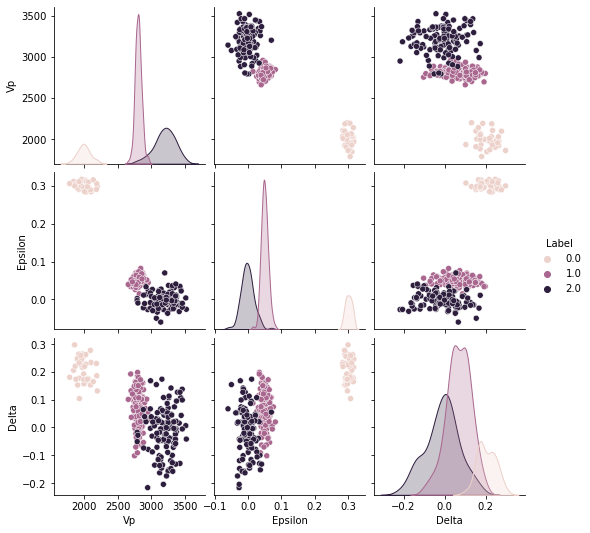

In [16]:
sns.pairplot(df_prior,hue="Label")

#### Measurements
Second, we load the measurements needed to perform our parametrical prediction for the feature $Delta$.

These spatial measurements are a function of the parameters $Vp$, $Epsilon$ and $Delta$. We will use them to obtain our unknown parameter $Delta$. This spatial measurement $d$ has a spatial coordinate $Angle$ and is a function of parameters $Vp$, $Epsilon$, and $Delta$, defined as (This work uses phase velocity defined by Thomsen, 1986):

\begin{equation}
d =f(Vp,Epsilon,Delta)=Vp(1+Delta\sin^2(Angle)\cos^2(Angle)+Epsilon\sin^4(Angle))
\end{equation}

We generate a synthetic measurements dataset by proposing a unique set of parameters $Vp$, $Epsilon$ and $Delta$ (this set of parameters is close to one of the generated populations). We calculate synthetic measurements for different $Angle$ values, adding random noise to each measurement.

In [17]:
#Synthetic Measurements Parameters
n_measurements=5                                             # number of measurements per location
angles=[-90,-67.5,-45,-22.5,0,22.5,45,67.5,90]               # location coordinates (1D: angle)
Vp=2200                                                      
Epsilon=0.3
Delta=0.18
Measurement_noise=100                                        # added noise (when noise is zero, regression does not work properly)

#Synthetic Model (Function of Vp, Epsilon and Delta)                                       
Measurement=[]                                               # dataframe generation with same steps as for the prior data
Angle=[]                                                   
for n in range(n_measurements):
    meas_draft=np.zeros(len(angles))
    angle_draft=np.zeros(len(angles))
    for m in range(len(angles)):
        meas_draft[m]=Vp*(1+Delta*(np.sin(angles[m]*np.pi/180)**2*np.cos(angles[m]*np.pi/180)**2)+Epsilon*np.sin(angles[m]*np.pi/180)**4)
        meas_draft[m]=meas_draft[m]+np.random.normal(loc = 0.0,scale=Measurement_noise,size=1)
        angle_draft[m]=angles[m]
    Measurement=(*Measurement,*meas_draft)
    Angle=(*Angle,*angle_draft)
d = {'Angle': Angle, 'Velocity': Measurement}
df_measurements = pd.DataFrame(data=d)

#Expected function without any noise
Angle_Model=np.linspace(-90,90,200)                                #true model to compare against measurements
Meas_Model=np.zeros(len(Angle_Model))
for n in range(len(Angle_Model)):
    Meas_Model[n]=Vp*(1+Delta*(np.sin(Angle_Model[n]*np.pi/180)**2*np.cos(Angle_Model[n]*np.pi/180)**2)+Epsilon*np.sin(Angle_Model[n]*np.pi/180)**4)

The next figure shows the syntetic model, based on ideal $Vp$, $Epsilon$, and $Delta$ and the measurements we will use to estimate $Delta$ parameter.
We observe that, depending on the noise that we assign, measurements will move further away from the true synthetic values.

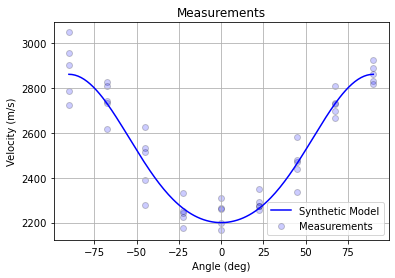

In [18]:
plt.scatter(df_measurements.Angle,df_measurements.Velocity, color = 'blue',edgecolor='black',alpha=0.2,label='Measurements')
plt.plot(Angle_Model,Meas_Model,'blue', label='Synthetic Model')
plt.title('Measurements'); plt.xlabel('Angle (deg)'); plt.ylabel('Velocity (m/s)')
plt.legend(); plt.grid()
plt.show()

<a id='section_2'></a>
### 2. Clustering
Prior data includes data from multiple populations. We expect that regression with data from multiple populations used as prior data can cause bias during the regression and increase estimated uncertainty for the predicted parameter.

We apply density-based clustering to identify populations. To simplify the problem we use only two parameters for this clustering: $Vp$ and $Velocity$. Density-based clustering is a distance-based method, so we standardize the data before clustering.

The obtained figures show clustering performed in standardized and non-standardized spaces. Also, it shows the proportion between identified clusters (including non-identified samples).

The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubsurfaceDataAnalytics_advanced_clustering.ipynb from GeostatsGuy GitHub.
Link: https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_advanced_clustering.ipynb

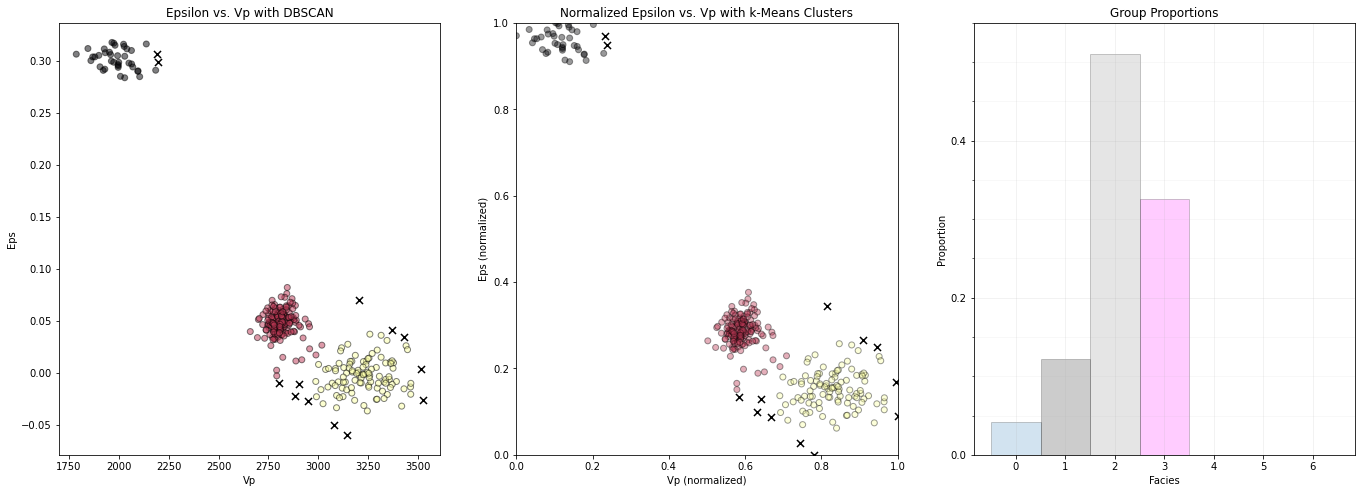

In [19]:
#Generation of standardized variables
col = ['Vp','Epsilon','Delta']
transform = MinMaxScaler(); 
features = [col[0],col[1]]

df_prior['n' + col[0]] = transform.fit_transform(df_prior.loc[:,features].values)[:,0] # standardize the data features to mean = 0, var = 1.0
df_prior['n' + col[1]] = transform.fit_transform(df_prior.loc[:,features].values)[:,1] # standardize the data features to mean = 0, var = 1.0
df_prior['n' + col[2]] = transform.fit_transform(df_prior.loc[:,features].values)[:,1] # standardize the data features to mean = 0, var = 1.0

#Clustering and visualization
dbscan = DBSCAN(eps=0.06, min_samples=15).fit(df_prior[['n'+col[0],'n'+col[1]]].values)
df_prior['DBSCAN'] = dbscan.labels_ + 1

cmap = plt.cm.inferno

plt.subplot(131)                          # plot the assigned training data and K prototypes
df_in = df_prior.loc[(df_prior['DBSCAN'] != 0)]
plt.scatter(df_in[col[0]], df_in[col[1]], c=df_in['DBSCAN'], alpha=0.5, edgecolor='k', cmap = cmap)
df_outlier = df_prior.loc[(df_prior['DBSCAN'] == 0)]
plt.scatter(df_outlier[col[0]],df_outlier[col[1]],c='black',s = 50,marker = 'x',edgecolor='k',cmap = cmap)
plt.title(col[1] + ' vs. ' + col[0] + ' with DBSCAN'); plt.xlabel('Vp'); plt.ylabel('Eps')
# plt.xlim(xlim)
# plt.ylim(ylim)

plt.subplot(132)                          # plot the training data and K prototypes
plt.scatter(df_in['n'+col[0]], df_in['n'+col[1]], c=df_in['DBSCAN'], alpha = 0.4, linewidths=1.0, edgecolors="black", cmap = cmap)
plt.scatter(df_outlier['n'+col[0]],df_outlier['n'+col[1]],c='black',s = 50,marker = 'x',edgecolor='k',cmap = cmap)
# option to visualize the identified core samples
#plt.scatter(dbscan.components_[:,0],dbscan.components_[:,1],c='red',s=50,marker = 's',edgecolor='k',cmap = cmap,alpha = 0.2)
plt.title('Normalized ' + col[1] + ' vs. ' + col[0] + ' with k-Means Clusters'); plt.xlabel('Vp (normalized)'); plt.ylabel('Eps (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2)

plt.subplot(133)
N, bins, patches  = plt.hist(df_prior['DBSCAN'],alpha=0.2,edgecolor="black",bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5],range=[0.5,2.5],density = True)
patches[1].set_facecolor('black'); patches[3].set_facecolor('magenta'); patches[4].set_facecolor('red')
patches[5].set_facecolor('yellow'); patches[6].set_facecolor('white'); patches[2].set_facecolor('gray');
plt.title('Group Proportions')
plt.xlabel('Facies')
plt.ylabel("Proportion")
ax = plt.gca()
ax.set_xticks(np.arange(0.0, 6.1, 1))
ax.set_yticks(np.arange(0, 0.6, 0.2))
ax.set_yticks(np.arange(0, 0.6, 0.05), minor=True)

#plt.grid(which = 'both',color = 'black',alpha = 0.01)
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.2)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.50, wspace=0.2, hspace=0.2)

Depending on the proximity between populations, the workflow can found either the same or a lowe number of clusters.

COMMENT: The workflow is designed to optimally work with up to 4 populations: the unclustered population and 3 identified clusters.

<a id='section_3'></a>
### 3. Prior and likelihood probability spaces
We assume that prior and likelihood probabilities are multivariate normal distributions.
For a single variable, probability is defined as:

\begin{equation}
\large p(x)=\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})}
\end{equation}

The multivariate approach follows that:

\begin{equation}
\large p(\mathbf{m})=\frac{1}{((2\pi)^Mdet\Sigma)^{1/2}}e^{-\frac{1}{2}((\mathbf{m}-\mu)^T\Sigma^{-1}(\mathbf{m}-\mu))}
\end{equation}

where $\mathbf{m}$ is the multivariate coordinate vector, $\mu$ is the multivariate mean vector and $\Sigma$ is the covariance matrix.

Bayes' rule for multivariate data will be:

\begin{equation}
\large p(\mathbf{m}|\mathbf{d},\mathcal{I})=\frac{p(\mathbf{m}|\mathcal{I})p(\mathbf{d}|\mathbf{m},\mathcal{I})}{p(\mathbf{d}|\mathcal{I})}
\end{equation}

where $\mathbf{m}$ is the parameters vector and $mathbf{d}$ is the mesurements vector.
Metropolis-Hastings sampling is defined based on current vs candidate steps' posterior ratios. Each step shares same denominator, reducing the analysis to the exponential components of each prior and likelihood probability. Consequently, for practical purposes, we represent the probability using only the logarithm component of each probability. 
The prior $logp(\mathbf{m}|\mathcal{I})$, independent of the measurement $\mathbf{d}$ is:

\begin{equation}
\large logp(\mathbf{m}|\mathcal{I})={-\frac{1}{2}((\mathbf{m}-\mu \scriptstyle prior \textstyle)^T \Sigma\scriptstyle prior \textstyle ^{-1}(\mathbf{m}-\mu \scriptstyle prior \textstyle))}
\end{equation}

The likelihood $logp(\mathbf{d}|\mathbf{m},\mathcal{I})$ describes whether a set of predicted measurements $\mathbf{d'}$ agrees with the observed measurements $\mathbf{d}$:

\begin{equation}
\large logp(\mathbf{d}|\mathbf{m},\mathcal{I})={-\frac{1}{2}((\mathbf{d}-\mathbf{d'})^T \Sigma\scriptstyle error \textstyle^{-1}(\mathbf{d}-\mathbf{d'}))}
\end{equation}

where $\Sigma\scriptstyle error$ is the observed error in the measurements (in our case, the noise we added when we created the data)

The following figures compares, in the logarithmic domain, the prior and likelihood probabilities for the unclustered data and for each identified cluster. The prior is represented as a surface map, while the likelihood is represented by points.
The main features we observe are:
1. Prior and likelihood probabilities are defined in 3-dimensional space, however we map their values only in the $Vp-Delta$ plane for a constant value of $Epsilon$, since we already know the value of that parameter. Prior probability decays within a $Vp-Delta$ plane when mean $Epsilon$ for each cluster is away from the observed $Epsilon$
2. Likelihood probability is independent of clustering
3. Data sparsity in the unclustered dataset implies a smoother prior surface when compared to prior probability surfaces for clustered populations
4. NOTE: more negative values imply lower probabilities!!! (remember that log(1)=0)

COMMENT: Processing can take up to around 1 minute depending on the computer

Reference: Malinverno, A. and Briggs, V.A. (2004) Expanded Uncertainty Quantification in Inverse Problems: Hierarchical Bayes and Empirical Bayes. Geophysics, 69, 877-1103. https://doi.org/10.1190/1.1778243

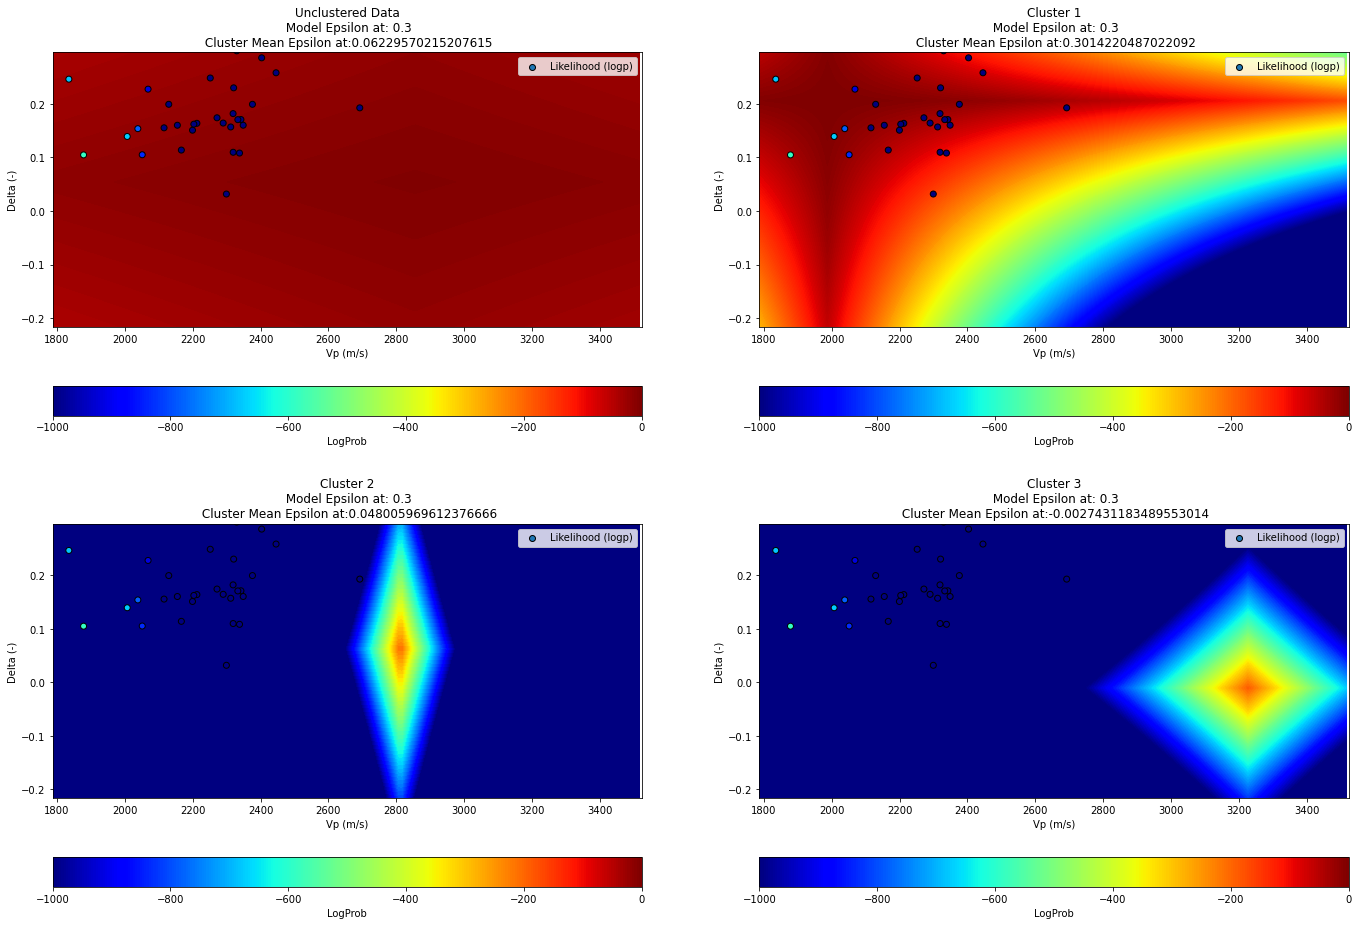

In [20]:
#Calculation of prior and likelihood over a Vp-Delta plane using constant parameter Epsilon
xx_Vp, yy_Delta = np.meshgrid(np.arange(np.min(df_prior.Vp), np.max(df_prior.Vp), 10),         #mesh based on Vp and Delta values
                     np.arange(np.min(df_prior.Delta), np.max(df_prior.Delta), 0.001))
#Inverse covariance for measurements (we assume that is constant for all measurements)
Sigma=100                                                                     #Standard error assumed for my data during inversion
InvCovErrors=(1/Sigma**2)*np.identity(len(Meas_Model))

#Calculation of likelihood. Samples are randomly distanced assuming gaussian distributions for each parametrical input
Vp_samples=np.zeros(30)
Delta_samples=np.zeros(30)
LikeLogP_samples=np.zeros(30)
for n in range(30):
    Vp_samples[n] = Vp + np.random.normal(loc = 0.0,scale=200,size=1)                   #Vp random sampling
    Delta_samples[n] = Delta + np.random.normal(loc = 0.0,scale=0.05,size=1)            #Delta random sampling
    for m in range(len(Meas_Model)):
        Vector=Vp_samples[n]*(1+Delta_samples[n]*(np.sin(Angle_Model[m]*np.pi/180)**2*np.cos(Angle_Model[m]*np.pi/180)**2)+Epsilon*np.sin(Angle_Model[m]*np.pi/180)**4)  #d' model for proposed Vp and Delta
    LikeLogP_samples[n]=Function_LogP(Meas_Model,Vector,InvCovErrors)                  #Likelihood for each point

#Calculation of prior. Values are calculated over the generated mesh
for n in range(np.max(df_prior.DBSCAN)+1):
    if n==0:
        df=df_prior
    else:
        df=df_prior[df_prior.DBSCAN==n]
    [Prior_CovMatrix, Prior_InvCovMatrix, Prior_Means]=ClustertoPrior(df.Vp.values,df.Epsilon.values,df.Delta.values)   #Prior means and covariances
    ZZ_p=PriorProbabilityVPDelta(xx_Vp,yy_Delta,Prior_InvCovMatrix,Prior_Means)                                         #Prior probability for each Vp and Delta value
#Plots and subplots
    plt.subplot(2,2,n+1)
    im1 = plt.contourf(xx_Vp, yy_Delta, ZZ_p,500,cmap=plt.cm.jet,norm=None,vmin=-1000,vmax=0)
    im2 = plt.scatter(Vp_samples,Delta_samples,c=LikeLogP_samples,cmap=plt.cm.jet,norm=None,vmin=-1000,vmax=0,edgecolor='black',label='Likelihood (logp)')
    plt.title(cluster[str(n)]+'\n Model Epsilon at: '+ str(Epsilon) +'\n Cluster Mean Epsilon at:' + str(Prior_Means[1]))
    plt.xlabel('Vp (m/s)'); plt.ylabel('Delta (-)')
    plt.xlim(np.min(df_prior.Vp),np.max(df_prior.Vp)); plt.ylim(np.min(df_prior.Delta),np.max(df_prior.Delta))
    plt.legend()
    cbar2 = plt.colorbar(im2, orientation = 'horizontal')
    cbar2.set_label("LogProb")

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3, wspace=0.2, hspace=0.2)

<a id='section_4'></a>
### 4. Regression: Metropolis-Hastings Sampling

We use Metropolis-Hastings sampling to estimate the unknown parameter $Delta$.
The regression workflow is as following:
1. Choose an initial value for candidate $Delta$
2. Calculate candidate measurements $d'$ based on $Vp$, $Epsilon$ and candidate $Delta$
3. Use candidate $Delta$ and $d'$ to calculate prior and likelihood $logp$, respectively
4. Vary existent $Delta$ using a random step and recalculate $d'$
5. Calculate prior and likelihood $logp$ for the new step
6. We define the acceptance comparing priors and likelihood before and after a step $t$ as:
\begin{equation}
logp(acceptance)=min((logp \scriptstyle prior \textstyle (t+1) + logp \scriptstyle posterior \textstyle(t+1) - logp \scriptstyle prior \textstyle (t)-logp \scriptstyle posterior \textstyle (t)),0)
\end{equation}
7. We accept the candidate if $logp(acceptance$ is higher than a threshold $alpha$
8. We repeat steps 4. to 7. $T$ times

During the analysis we track two main values for every step: accepted parameter $Delta$ and accuracy as the ratio between accepted candidates over the number of iterations.

COMMENT 1: Processing takes 5-10 minutes

COMMENT 2: TotalIteration is currently setup to have burn-in-chain and posterior-chain in all the parametrical regressions

Reference: Malinverno, A. and Briggs, V.A. (2004) Expanded Uncertainty Quantification in Inverse Problems: Hierarchical Bayes and Empirical Bayes. Geophysics, 69, 877-1103.
https://doi.org/10.1190/1.1778243

In [21]:
#Parametrical regression parameters
TotalIterations=30000                                                         #Chain length
Step=0.1                                                                     #Step size between each chain component


X0Output=np.zeros([np.max(df_prior.DBSCAN)+1,TotalIterations])                                           #Output value
Accuracy=np.zeros([np.max(df_prior.DBSCAN)+1,TotalIterations])                                           #Accuracy: accepted/total trials

ff1Candidate=np.zeros(len(Meas_Model))                                       #Candidate model measurements d'
ff1Current=np.zeros(len(Meas_Model))                                         #Current (accepted) model measurements d'
Deltameans=np.zeros(len(df_prior.DBSCAN)+1)
#We repeat the iteration for every dataset
for k in range(np.max(df_prior.DBSCAN)+1):
    Current=np.random.normal(loc = 0.0,scale=0.1,size=1)                         #Current (accepted) value
    VelModel=np.array([Vp,Epsilon,Current[0]])                               #Predictor set (with initial value)
    accepted=0                                                                   #How many samples were accepted
    if k==0:
        df=df_prior                                                          #Analysis of unclustered data
    else:
        df=df_prior[df_prior.DBSCAN==k]                                      #Analysis of unclustered data
    [Prior_CovMatrix, Prior_InvCovMatrix, Prior_Means]=ClustertoPrior(df.Vp.values,df.Epsilon.values,df.Delta.values)  #Prior data parameters
    Deltameans[k]=Prior_Means[2]
    LogPriorPCurr=Function_LogP(VelModel,Prior_Means,Prior_InvCovMatrix)                                               #logp calculation for prior
    for m in range(len(Meas_Model)):
        ff1Current=Vp*(1+Current*(np.sin(Angle_Model[m]*np.pi/180)**2*np.cos(Angle_Model[m]*np.pi/180)**2)+Epsilon*np.sin(Angle_Model[m]*np.pi/180)**4)    #d' for initial value
    LogLikePCurr=Function_LogP(Meas_Model,ff1Current,InvCovErrors)                                                     #logp calculation for likelihood
#Add a random step to the previous value and repeat prior, d' and likelihood calculations
    for n in range(1,TotalIterations):
        Candidate=Current+Step*np.random.normal(loc = 0.0,scale=0.1,size=1)
        VelModel=np.array([Vp,Epsilon,Candidate[0]])
        LogPriorPCand=Function_LogP(VelModel,Prior_Means,Prior_InvCovMatrix)
        for m in range(len(Meas_Model)):
            ff1Candidate[m]=Vp*(1+Candidate*(np.sin(Angle_Model[m]*np.pi/180)**2*np.cos(Angle_Model[m]*np.pi/180)**2)+Epsilon*np.sin(Angle_Model[m]*np.pi/180)**4)
        LogLikePCand=Function_LogP(Meas_Model,ff1Candidate,InvCovErrors)
#Define logp(acceptance) as the minimum value between candidate and current model difference or 0.
#When the probability of the candidate is higher than the current value, then p(acceptance) is 1 (or logp=1)
        LogProb=np.min([0,(LogPriorPCand+LogLikePCand-LogPriorPCurr-LogLikePCurr)])
#Compare my logp(candidate) against a threshold obtained from a normal distribution (ranging from 0 to 1). I accept the candidate if the probability is higher than my threshold
        if np.log(np.abs(np.random.normal(loc = 0.0,scale=Measurement_noise,size=1))) < LogProb:
#If I accept the candidate, then
            Current=Candidate                                             #update current value
            LogPriorPCurr=LogPriorPCand                                   #update logp for prior
            LogLikePCurr=LogLikePCand                                     #update logp for likelihood
            ff1Curr=ff1Candidate                                          #update model measurements d'
            accepted=accepted+1                                           #increase the number of accepted candidates
#For every step, my output is
        X0Output[k,n]=Current                                             #the last accepted candidate
        Accuracy[k,n]=accepted/n                                          #accuracy as the radio of accepted candidates over performed steps

<a id='section_5'></a>
### 5. Results
Regression analysis shows that regression converge to different values for unclustered and clustered populations.
We can distinguish 3 main behaviors:
1. Unclustered data: Tends to model $Delta$ with a high bias towards the mean $Delta$ of the unclustered population. Posterior-chain values show the highest standard deviation. Figure shows that bias between the estimated value and true model value is the highest. Accuracy of this model is the highest as well, with a high acceptance rate.
2. Clustered data (correct population): Estimated $Delta$ closer to the true model value (minimum bias). Low standard deviation and lower acceptance rate when compared to unclustered data.
3. Clustered data (incorrect population): Biased $Delta$ toward cluster mean value. Standard deviation and accuracy are low, showing the lowest acceptance rates. COMMENT: This case can represent the risk of ignoring the 'no-free-luch theorem'; using an incorrect prior can generate significative bias during regression!

Unclustered Data mean: 0.16382814614490543 and std: 0.016967893123824344
Cluster 1 mean: 0.2060079510720144 and std: 0.0008927320264181382
Cluster 2 mean: 0.06239950499207963 and std: 0.0007241737565552209
Cluster 3 mean: -0.010379977691459059 and std: 0.0003093381089567974


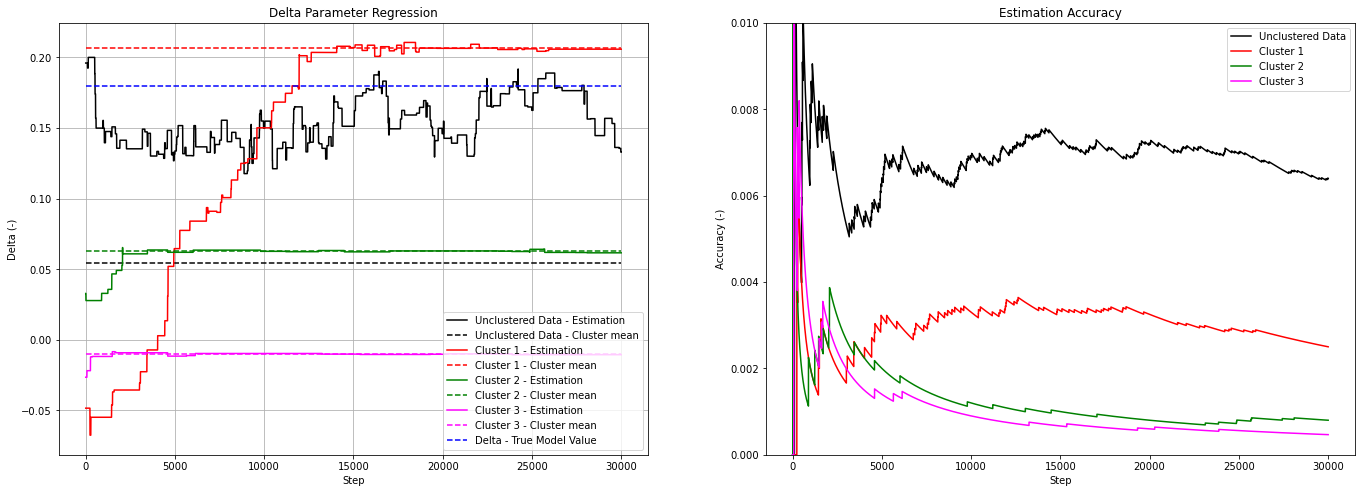

In [22]:
plt.subplot(1,2,1)
for k in range(np.max(df_prior.DBSCAN)+1):
    plt.plot(X0Output[k,1:],color[str(k)],label=cluster[str(k)]+' - Estimation')
    plt.title('Delta Parameter Regression'); plt.xlabel('Step'); plt.ylabel('Delta (-)')
    plt.plot([0,TotalIterations],[Deltameans[k],Deltameans[k]],color[str(k)],linestyle='dashed',label=cluster[str(k)]+' - Cluster mean')
plt.plot([0,TotalIterations],[Delta,Delta],'blue',linestyle='dashed',label='Delta - True Model Value')
plt.legend(); plt.grid()

plt.subplot(1,2,2)
for k in range(np.max(df_prior.DBSCAN)+1):
    plt.plot(Accuracy[k,1:],color[str(k)],label=cluster[str(k)])
    plt.ylim(0,0.01)
    plt.title('Estimation Accuracy'); plt.xlabel('Step'); plt.ylabel('Accuracy (-)')
    plt.legend(); plt.grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.5, wspace=0.2, hspace=0.2)

burnend=20000
for k in range(np.max(df_prior.DBSCAN)+1):
    print(cluster[str(k)]+' mean: '+str(np.mean(X0Output[k,burnend:]))+' and std: '+str(str(np.std(X0Output[k,burnend:]))))



Now, we compare the estimated model values from clustered and unclustered against available measurements.

We observe that:
- even though when the estimated $Delta$ parameters is closer to the true model value, depending on the measurements uncertainty, mean squared errors can be lower when we compare low-bias to high-bias clusters
- in areas with low prior probabilities, likelihood (calculated from the model error) has a higher weight during the regression.

Unclustered Data mean squared error: 110398.76767592314
Cluster 1 mean squared error: 112749.75211985795
Cluster 2 mean squared error: 106067.31120174391
Cluster 3 mean squared error: 104109.92454278149


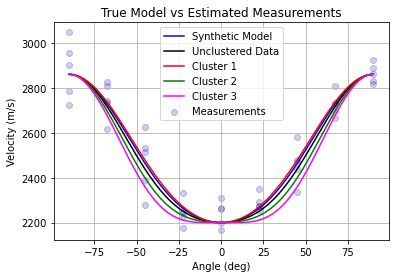

In [23]:
Meas_InvModel=np.zeros([np.max(df_prior.DBSCAN)+1,len(Angle_Model)])
Meas_InvScatterModel=np.zeros(len(df_measurements.Angle.values))
Meas_sq_errors=np.zeros(len(df_prior.DBSCAN))
for k in range(np.max(df_prior.DBSCAN)+1):
    for n in range(len(Angle_Model)):
        Meas_InvModel[k,n]=Vp*(1+np.mean(X0Output[k,burnend:])*(np.sin(Angle_Model[n]*np.pi/180)**2*np.cos(Angle_Model[n]*np.pi/180)**2)+Epsilon*np.sin(Angle_Model[n]*np.pi/180)**4)
    for n in range(len(df_measurements.Angle.values)):
        Meas_InvScatterModel[n]=Vp*(1+np.mean(X0Output[k,burnend:])*(np.sin(Angle_Model[n]*np.pi/180)**2*np.cos(Angle_Model[n]*np.pi/180)**2)+Epsilon*np.sin(Angle_Model[n]*np.pi/180)**4)
    Meas_sq_errors[k]=np.mean((Meas_InvScatterModel-df_measurements.Velocity.values)**2)
    print((cluster[str(k)]+' mean squared error: '+str(Meas_sq_errors[k])))

    for n in range(len(Angle_Model)):
        Meas_InvModel[k,n]=Vp*(1+X0Output[k,TotalIterations-1]*(np.sin(Angle_Model[n]*np.pi/180)**2*np.cos(Angle_Model[n]*np.pi/180)**2)+Epsilon*np.sin(Angle_Model[n]*np.pi/180)**4)

plt.scatter(df_measurements.Angle,df_measurements.Velocity, color = 'blue',edgecolor='black',alpha=0.2,label='Measurements')
plt.plot(Angle_Model,Meas_Model,'blue', label='Synthetic Model')
for k in range(np.max(df_prior.DBSCAN)+1):
    plt.plot(Angle_Model,Meas_InvModel[k,:],color[str(k)],label=cluster[str(k)])
plt.title('True Model vs Estimated Measurements'); plt.xlabel('Angle (deg)'); plt.ylabel('Velocity (m/s)')
plt.legend(); plt.grid()
plt.show()

### Parting Comments
- This code shows the effects on regression for the estimation of a single parameter by assuming that the other two measurements are already known.
- While we performed the regression for a single parameters, we can extend the code to invert for all three parameters just by rotating the step between parameters during regression.


I hope this was helpful,

Gabriel

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin